# Predicting Programming Languages In Github Repos Using NLP
## By Justin Sullivan
### May 10, 2021

---

## Project Overview & Summary

> - **Goal**
    - To build a classification model that more accurately predicts the primary programming language used in a github's repo based of the repo's readme contents. 
 
> - **Key Kindings**
    - The KNN model can assist Github users in filtering and identifying relevant repos by correctly predicting the primary programming language used 3 out of 4 times. That is an improvement of 36 percentage points over the baseline model.


---

In [1]:
import warnings
warnings.filter="ignore"

import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
import numpy as np
from env import github_token, github_username

import prepare
import acquire
import explore
import model

import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup

## Acquire

In [2]:
#Use the scrape github function from the acquire module to acquire the dataframe containing the names of the
#repositories and the contents of the readme files
df = acquire.get_github_data(cached=True)
df.head()

,repo,language,readme_contents
0,ansible/ansible,Python,|PyPI version| |Docs badge| |Chat badge| |Buil...
1,TensorSpeech/TensorFlowTTS,Python,"<h2 align=""center"">\n<p> :yum: TensorFlowTTS\n..."
2,plurals/pluralize,JavaScript,# Pluralize\n\n[![NPM version][npm-image]][npm...
3,vczh/tinymoe,C++,tinymoe\n=======\n### English-like programming...
4,RHVoice/RHVoice,C++,# RHVoice\n\nRHVoice is a free and open source...


**Now that the data is acquired, I will explore the structure and content of the dataframe**

In [3]:
#Print the shape of the dataframe
print(f"The dataframe contains {df.shape[0]} rows, each representing the contents of one github readme file, and {df.shape[1]} columns.")

The dataframe contains 284 rows, each representing the contents of one github readme file, and 3 columns.


In [4]:
#Get the info on the df to determine dtypes and detect the presence of any nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284 entries, 0 to 283
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             284 non-null    object
 1   language         263 non-null    object
 2   readme_contents  279 non-null    object
dtypes: object(3)
memory usage: 8.9+ KB


> **Takeaways from Acquire:**
    > - Missing null values in language column will have to be dealt with
    > - All dtypes are objects, as expected, so I will not perform any descriptive stats at this point

---

## Prepare

> **Tasks Taken to Prepare the Data:**
    > - Deal with missing nulls in language. Since only 21  values are missing, I will just drop those obsevations.

In [5]:
#Prepare the data with the prep_github_repo_df function from the prepare module
#I will specify n=7 to drop any observtations that have programming languages occur less than 7 times in the df
df = prepare.prep_github_repo_df(df, n=7, extra_words=['language', 'customer'])
df.head(1)

/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,repo,language,readme_contents,clean,stemmed,lemmatized
0,ansible/ansible,Python,|PyPI version| |Docs badge| |Chat badge| |Buil...,pypi version docs badge chat badge build statu...,pypi version doc badg chat badg build statu co...,pypi version doc badge chat badge build status...


In [6]:
#Print the shape of the prepared dataframe
print(f"The dataframe contains {df.shape[0]} rows, each representing the contents of one github readme file, and {df.shape[1]} columns.")

The dataframe contains 209 rows, each representing the contents of one github readme file, and 6 columns.


In [7]:
#Check info and make sure there all null values have been removed
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209 entries, 0 to 283
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             209 non-null    object
 1   language         209 non-null    object
 2   readme_contents  209 non-null    object
 3   clean            209 non-null    object
 4   stemmed          209 non-null    object
 5   lemmatized       209 non-null    object
dtypes: object(6)
memory usage: 11.4+ KB


In [8]:
#On the first iteration I worked only with lemmatized words. However, after running my models with 
#the stemmed words on my second iteration, my best performing model improved 4 percentage points with 
#stemmed words than it did with the lemmatized words.

#I am going to work solely with the stemmed readme_contents for the remainder of this second iteration
#Reducing my df to contain onlt the columns repo,language, stemmed columns
df = df[['repo', 'language', 'stemmed']]
df.head(1)

,repo,language,stemmed
0,ansible/ansible,Python,pypi version doc badg chat badg build statu co...


---

## Exploration

### Explore the Distribution of Programming Languages Represented in Data

In [9]:
#First, I want to see which programming languages are represented in the prepared dataframe
#Create a list of the languages
languages = list(df.language.unique())
print(f'These are the programming languages represented in this dataframe {languages}')

These are the programming languages represented in this dataframe ['Python', 'JavaScript', 'C++', 'PHP', 'Ruby', 'HTML', 'Java', 'C#']


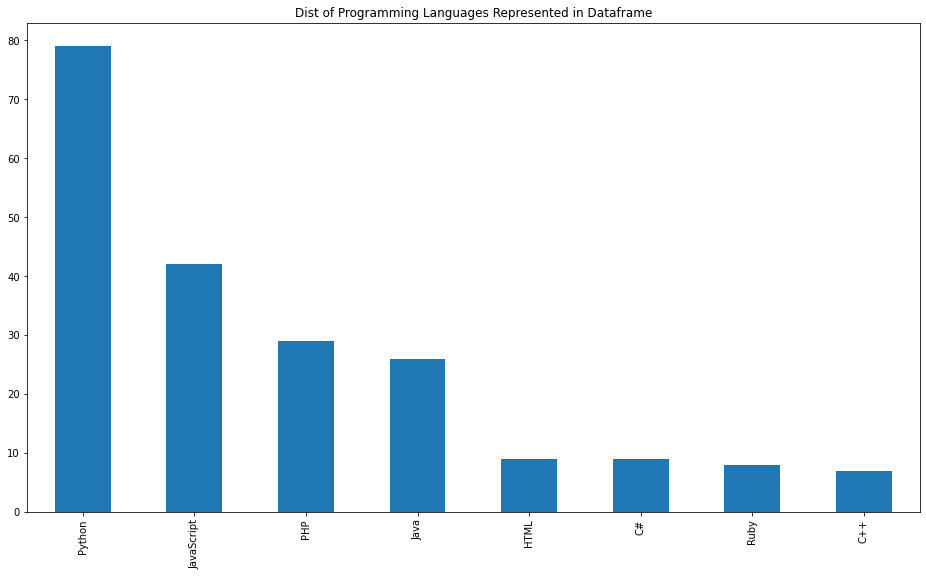

In [10]:
#Define figure size
plt.figure(figsize=(16, 9))

#Plot the distributions
df.language.value_counts().plot.bar(title="Dist of Programming Languages Represented in Dataframe")
plt.show()

### Explore Words and Frequencies by Programming Language

**I'll need to do some prepartion to begin**

In [12]:
#Define the words used in each repo broken down by programming language
Python_words = explore.get_words(' '.join(df.stemmed[df.language == 'Python']))
JavaScript_words = explore.get_words(' '.join(df.stemmed[df.language == 'JavaScript']))
Cplusplus_words = explore.get_words(' '.join(df.stemmed[df.language == 'C++']))
PHP_words = explore.get_words(' '.join(df.stemmed[df.language == 'PHP']))
Ruby_words = explore.get_words(' '.join(df.stemmed[df.language == 'Ruby']))
HTML_words = explore.get_words(' '.join(df.stemmed[df.language == 'HTML']))
Java_words = explore.get_words(' '.join(df.stemmed[df.language == 'Java']))
Chash_words = explore.get_words(' '.join(df.stemmed[df.language == 'C#']))

#Get the frequency for each word per programming language
Python_freq = pd.Series(Python_words).value_counts()
JavaScript_freq = pd.Series(JavaScript_words).value_counts()
Cplusplus_freq = pd.Series(Cplusplus_words).value_counts()
PHP_freq = pd.Series(PHP_words).value_counts()
Ruby_freq = pd.Series(Ruby_words).value_counts()
HTML_freq = pd.Series(HTML_words).value_counts()
Java_freq = pd.Series(Java_words).value_counts()
Chash_freq = pd.Series(Chash_words).value_counts()

#Create a dataframe with all the wordcounts by category
word_counts = (pd.concat([Python_freq, JavaScript_freq, Cplusplus_freq, PHP_freq, 
                          Ruby_freq, HTML_freq, Java_freq, Chash_freq], axis=1, sort=True)
                .set_axis(['Python','JavaScript','Cplusplus','PHP_words','Ruby','HTML','Java',
                           'Chash'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,Python,JavaScript,Cplusplus,PHP_words,Ruby,HTML,Java,Chash
0,371,2,4,5,2,2,2,0
00,28,0,0,0,0,0,0,0
0000001,1,0,0,0,0,0,0,0
000001,1,0,0,0,0,0,0,0
000002,1,0,0,0,0,0,0,0


In [13]:
word_counts.describe()

,Python,JavaScript,Cplusplus,PHP_words,Ruby,HTML,Java,Chash
count,14091.000000,14091.000000,14091.000000,14091.000000,14091.000000,14091.000000,14091.000000,14091.000000
mean,2.739834,0.622880,0.129089,0.578809,0.154638,0.239657,0.508906,0.109432
std,14.204334,3.273872,3.250836,3.305771,0.989944,1.380737,3.382811,0.911065
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1054.000000,138.000000,369.000000,154.000000,42.000000,44.000000,163.000000,48.000000


### Exploration with Wordclouds

**Python Language**

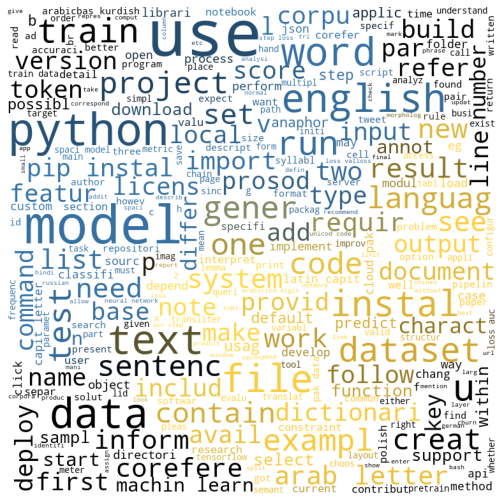

In [16]:
#Create a wordcloud

#Define figure size
plt.figure(figsize=(16, 9))

#Create the image ogject
mask = np.array(Image.open('python_logo.jpeg'))

#Set colors to the image object
image_colors = ImageColorGenerator(mask)

#Create the wordcloud image
img = WordCloud(background_color='white', mask=mask, max_words=300, color_func=image_colors, random_state=42, 
                max_font_size=100, width=1200, height=1200).generate(' '.join(Python_words))

#Show the image
plt.imshow(img)
plt.axis('off')
plt.show()

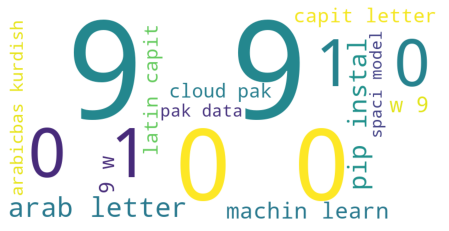

In [18]:
#Create a bigram of words
top_15_Python_bigrams = (pd.Series(nltk.ngrams(Python_words, 2)).value_counts().head(15))

#Create a wordcloud of the blog bigrams
data = {k[0] + ' ' + k[1]: v for k, v in top_15_Python_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

**JavaScript Language**

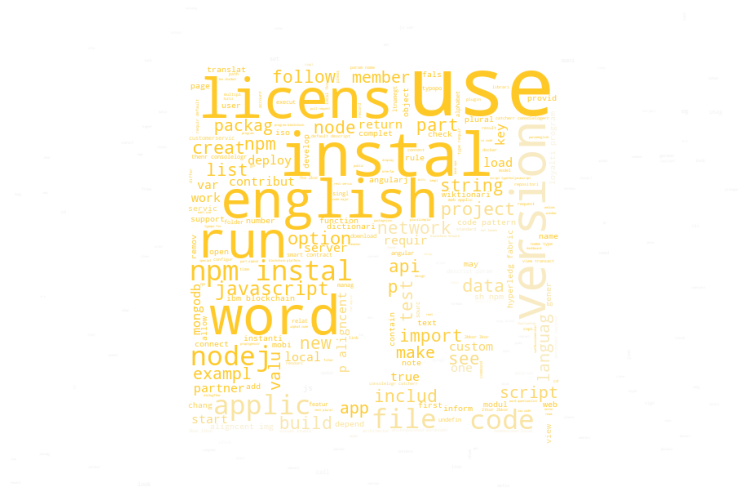

In [19]:
#Create a wordcloud

#Define figure size
plt.figure(figsize=(16, 9))

#Create the image ogject
mask = np.array(Image.open('js_logo.jpg'))

#Set colors to the image object
image_colors = ImageColorGenerator(mask)

#Create the wordcloud image
img = WordCloud(background_color='white', mask=mask, max_words=300, color_func=image_colors, random_state=42, 
                max_font_size=100, width=1200, height=1200).generate(' '.join(JavaScript_words))

#Show the image
plt.imshow(img)
plt.axis('off')
plt.show()

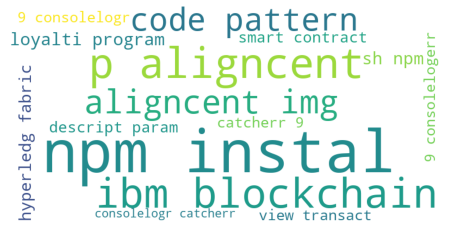

In [20]:
#Create a bigram of words
top_15_JS_bigrams = (pd.Series(nltk.ngrams(JavaScript_words, 2)).value_counts().head(15))

#Create a wordcloud of the blog bigrams
data = {k[0] + ' ' + k[1]: v for k, v in top_15_JS_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

**PHP Language**

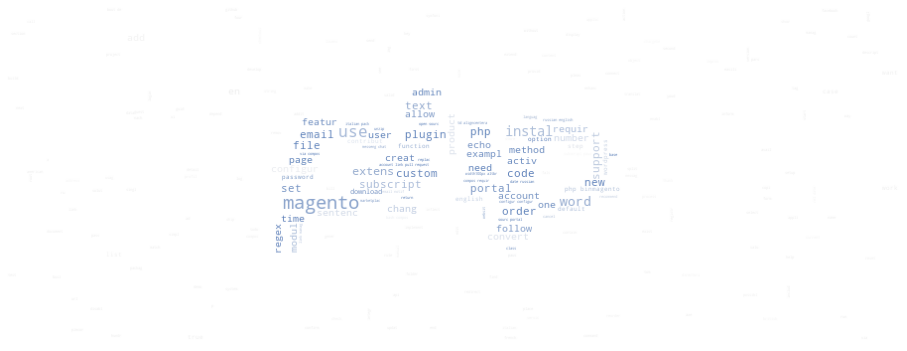

In [21]:
#Create a wordcloud

#Define figure size
plt.figure(figsize=(16, 9))

#Create the image ogject
mask = np.array(Image.open('php.jpg'))

#Set colors to the image object
image_colors = ImageColorGenerator(mask)

#Create the wordcloud image
img = WordCloud(background_color='white', mask=mask, max_words=300, color_func=image_colors, random_state=42, 
                max_font_size=100, width=1200, height=1200).generate(' '.join(PHP_words))

#Show the image
plt.imshow(img)
plt.axis('off')
plt.show()

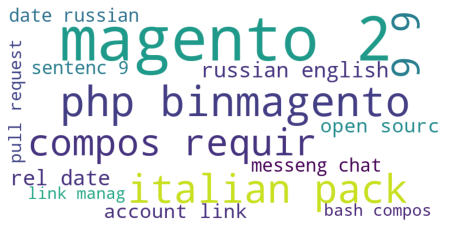

In [22]:
#Create a bigram of words
top_15_PHP_bigrams = (pd.Series(nltk.ngrams(PHP_words, 2)).value_counts().head(15))

#Create a wordcloud of the blog bigrams
data = {k[0] + ' ' + k[1]: v for k, v in top_15_PHP_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

> ### Takeaways:
    > - Language  and customer appears frequently in the these (during the first iteration)...I added those to the stopword list?
    > - Further exploration and visualization, inlcuding creating bigrams was completed in my project workbook that is included in this repository.

---

## Modeling

**Split the Data**

In [23]:
#Split the data using the split function from the model module
#Stratify by language
train, validate, test = model.split(df, 'language')

print(f'Train shape: {train.shape} \
        Validate shape: {validate.shape} \
        Test shape: {test.shape}')

Train shape: (116, 3)         Validate shape: (51, 3)         Test shape: (42, 3)


In [25]:
# Setup the X variables
X_train = train.stemmed
X_validate = validate.stemmed
X_test = test.stemmed

# Setup the y variables
y_train = train.language
y_validate = validate.language
y_test = test.language

**Vectorize the Data**

In [26]:
#Create the tfidf vectorizer object
tfidf = TfidfVectorizer()

#Fit the object on the training data
tfidf.fit(X_train)

#Use the object
X_train_vectorized =tfidf.transform(X_train)
X_validate_vectorized =tfidf.transform(X_validate) 
X_test_vectorized =tfidf.transform(X_test)

**Establish A Baseline Model**

In [27]:
#Establish baseline accuracy where the most frequently appearing proramming language in the dataframe
#becomes the assumed baseline prediction
df.language.value_counts()

Python        79
JavaScript    42
PHP           29
Java          26
HTML           9
C#             9
Ruby           8
C++            7
Name: language, dtype: int64

In [28]:
#Python is the baseline prediction
print(f'Baseline Accuracy: {round(max(df.language.value_counts()) / df.shape[0] *100)}%')

Baseline Accuracy: 38%


---

**Logistic Regression Model**

In [29]:
#Using the vectorized data, make a logistic regression model
lm = LogisticRegression()

#Fit the lm object to the vectorized data
lm.fit(X_train_vectorized, y_train)

#Create corresponding dataframes for the actual values of the categories that correspond to each article
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

#Form predictions uisng the lm model
train['predicted'] = lm.predict(X_train_vectorized)
validate["predicted"] = lm.predict(X_validate_vectorized)
test['predicted'] = lm.predict(X_test_vectorized)

#Review how the lm model performed on the in-sample data
print('In-sample data model performance:')
print(classification_report(train.actual, train.predicted, zero_division=0))
print('----------------')
#Review how the lm model performed on the out-of-sample data
print('Out-of-sample data model performance:')
print(classification_report(validate.actual, validate.predicted, zero_division=0))

In-sample data model performance:
              precision    recall  f1-score   support

          C#       0.00      0.00      0.00         5
         C++       0.00      0.00      0.00         4
        HTML       0.00      0.00      0.00         5
        Java       1.00      0.21      0.35        14
  JavaScript       1.00      0.96      0.98        24
         PHP       1.00      0.81      0.90        16
      Python       0.57      1.00      0.73        44
        Ruby       0.00      0.00      0.00         4

    accuracy                           0.72       116
   macro avg       0.45      0.37      0.37       116
weighted avg       0.68      0.72      0.64       116

----------------
Out-of-sample data model performance:
              precision    recall  f1-score   support

          C#       0.00      0.00      0.00         2
         C++       0.00      0.00      0.00         2
        HTML       0.00      0.00      0.00         2
        Java       1.00      0.29      0.44

> **Takeaways:**
> - Logistic regression model performs better than baseline with an accuracy of 49% on out-of-sample data
> - LM model os most accurate for predicting languages that are Java, JavaScript, PHP & Python. 

---

**KNN Model**

In [42]:
#Create the KNN object with a k = 7
knn = KNeighborsClassifier(n_neighbors=7, weights='distance')

#Fit the object to the vectorized training data
knn.fit(X_train_vectorized, y_train)

#Create corresponding dataframes for the actual values of the categories that correspond to each article
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

#Form predictions uisng the knn model
train['predicted'] = knn.predict(X_train_vectorized)
validate["predicted"] = knn.predict(X_validate_vectorized)

#Review how the knn model performed on the in-sample data
print('In-sample data model performance:')
print(classification_report(train.actual, train.predicted,  zero_division=0))
print('----------------')
#Review how the knn model performed on the out-of-sample data
print('Out-of-sample data model performance:')
print(classification_report(validate.actual, validate.predicted, zero_division=0))

In-sample data model performance:
              precision    recall  f1-score   support

          C#       1.00      1.00      1.00         5
         C++       1.00      1.00      1.00         4
        HTML       1.00      1.00      1.00         5
        Java       1.00      1.00      1.00        14
  JavaScript       1.00      1.00      1.00        24
         PHP       1.00      1.00      1.00        16
      Python       1.00      1.00      1.00        44
        Ruby       1.00      1.00      1.00         4

    accuracy                           1.00       116
   macro avg       1.00      1.00      1.00       116
weighted avg       1.00      1.00      1.00       116

----------------
Out-of-sample data model performance:
              precision    recall  f1-score   support

          C#       0.00      0.00      0.00         2
         C++       0.00      0.00      0.00         2
        HTML       0.00      0.00      0.00         2
        Java       0.62      0.71      0.67

> **Takeaways:**
> - KNN model performs better than baseline and logistic model with an accuracy of 73% on out-of-sample data
> - KNN model is most accurate for predicting the same languages as the lm model but there is less accuracy for the individual languages Java JavaScript, PHP & Python. 

---

**Random Forest Model**

In [31]:
#Create the RF object
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=2,
                            n_estimators=100,
                            max_depth=15, 
                            random_state=123)

#Fit the RF object to the training data
rf.fit(X_train_vectorized, y_train)

#Predict on y
y_pred = rf.predict(X_train_vectorized)

#Evaluate
print('In-sample data model performance:')
print(classification_report(y_train, y_pred))

In-sample data model performance:
              precision    recall  f1-score   support

          C#       1.00      0.60      0.75         5
         C++       1.00      0.50      0.67         4
        HTML       1.00      0.40      0.57         5
        Java       1.00      0.64      0.78        14
  JavaScript       1.00      1.00      1.00        24
         PHP       1.00      1.00      1.00        16
      Python       0.77      1.00      0.87        44
        Ruby       1.00      0.75      0.86         4

    accuracy                           0.89       116
   macro avg       0.97      0.74      0.81       116
weighted avg       0.91      0.89      0.88       116



In [32]:
#Predict using out of sample data
y_pred = rf.predict(X_validate_vectorized)
print('----------------')
print('Out-of-sample data model performance:')
print(classification_report(y_validate, y_pred, zero_division=0))

----------------
Out-of-sample data model performance:
              precision    recall  f1-score   support

          C#       0.00      0.00      0.00         2
         C++       0.00      0.00      0.00         2
        HTML       0.00      0.00      0.00         2
        Java       1.00      0.29      0.44         7
  JavaScript       0.67      0.40      0.50        10
         PHP       0.00      0.00      0.00         7
      Python       0.44      1.00      0.61        19
        Ruby       0.00      0.00      0.00         2

    accuracy                           0.49        51
   macro avg       0.26      0.21      0.19        51
weighted avg       0.43      0.49      0.39        51



> **Takeaways:**
> - RF was overfit as it performed with 91% accuracy on in-sample data, but the accuracy dropped to 53% for
the out of sample data

---

**Decision Tree Modeling**

In [33]:
#Make the CLF object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=9, random_state=123)

#Fit the model on the training set 
clf = clf.fit(X_train_vectorized, y_train)

#Make predictions
y_pred = clf.predict(X_train_vectorized)

#Evaluate model performance on training data
print('In-sample data model performance:')
print(classification_report(y_train, y_pred))

In-sample data model performance:
              precision    recall  f1-score   support

          C#       1.00      1.00      1.00         5
         C++       0.80      1.00      0.89         4
        HTML       1.00      0.60      0.75         5
        Java       1.00      0.71      0.83        14
  JavaScript       1.00      1.00      1.00        24
         PHP       1.00      1.00      1.00        16
      Python       0.90      1.00      0.95        44
        Ruby       1.00      1.00      1.00         4

    accuracy                           0.95       116
   macro avg       0.96      0.91      0.93       116
weighted avg       0.95      0.95      0.94       116



In [34]:
# Predict on validate
y_pred = clf.predict(X_validate_vectorized)

# Evaluate model performance on out-of-sample data
print('Out-of-sample data model performance:')
print(classification_report(y_validate, y_pred, zero_division=0))

Out-of-sample data model performance:
              precision    recall  f1-score   support

          C#       0.00      0.00      0.00         2
         C++       0.00      0.00      0.00         2
        HTML       0.00      0.00      0.00         2
        Java       0.33      0.14      0.20         7
  JavaScript       0.60      0.60      0.60        10
         PHP       0.27      0.43      0.33         7
      Python       0.46      0.58      0.51        19
        Ruby       0.00      0.00      0.00         2

    accuracy                           0.41        51
   macro avg       0.21      0.22      0.21        51
weighted avg       0.37      0.41      0.38        51



> **Takeaways:**
> - The Decision Tree model only achieves 49% accuracy on out of sample data
> - At this point, the KNN model achieves the highest accuracy score on out of sample data

<div class="alert alert-block alert-info"><b>Modeling Takeaway:</b> The KNN model is the best performing model with an accuracy score of 69% on out-of-sample data. The KNN model will be carried forward and evaluated on the test data set.</div>

---

**Evaluate the Best Performing Model on the Test Data**

In [43]:
test['predicted'] = knn.predict(X_test_vectorized)
print('Out-of-sample data model performance:')
print(classification_report(test.actual, test.predicted, zero_division=0))

Out-of-sample data model performance:
              precision    recall  f1-score   support

          C#       1.00      1.00      1.00         2
         C++       0.00      0.00      0.00         1
        HTML       0.00      0.00      0.00         2
        Java       0.75      0.60      0.67         5
  JavaScript       0.64      0.88      0.74         8
         PHP       0.83      0.83      0.83         6
      Python       0.74      0.88      0.80        16
        Ruby       0.00      0.00      0.00         2

    accuracy                           0.74        42
   macro avg       0.49      0.52      0.50        42
weighted avg       0.66      0.74      0.69        42



In [52]:
#View the confusion matrix for how the predictions vs actuals aligned 
print(pd.crosstab(test.actual, test.predicted))

predicted   C#  Java  JavaScript  PHP  Python
actual                                       
C#           2     0           0    0       0
C++          0     0           0    0       1
HTML         0     0           0    0       2
Java         0     3           2    0       0
JavaScript   0     0           7    0       1
PHP          0     0           0    5       1
Python       0     0           2    0      14
Ruby         0     1           0    1       0


> **Takeaways:**
> - The KNN model achieved 74% on the test (out-of-sample) dataset.

---

## Conclusion

- **The KNN Model improves upon the baseline accuracy by 36 percentage points**
- **This model can assist Github users in filtering relevant repositories by returning 3 out of 4 repos with in target programming language**
- **This model can be furthered imporved by gathering more data, especially observations including programming languages that underrepresented in this study of 209 observations**